In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AVTVYWwOyJBSBw0jbFQf")
project = rf.workspace("taco-9911u").project("taco-trash-annotations-in-context-bumvw")
version = project.version(10)
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TACO:-Trash-Annotations-in-Context-Dataset-10 in coco:: 100%|██████████| 3173/3173 [00:01<00:00, 2331.20it/s]


In [2]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.5 ; cuda:  cu121
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-bhf3nhro
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-bhf3nhro
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
from detectron2.data.datasets import register_coco_instances # registers your dataset in the COCO format with detectron2 so that you can use it for training and testing.
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_test", {}, "/content/valid/_annotations.coco.json", "/content/valid")


WARNING [01/14 16:19:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/14 16:19:13 d2.data.datasets.coco]: Loaded 3057 images in COCO format from /content/train/_annotations.coco.json


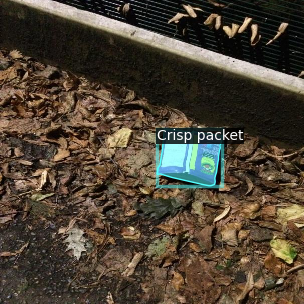

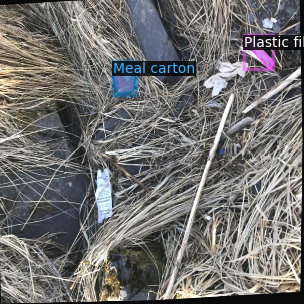

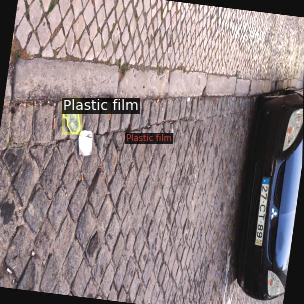

In [3]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [19]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 360 # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 22  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[01/14 16:41:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[01/14 16:41:55 d2.engine.hooks]: Loading scheduler from state_dict ...
[01/14 16:41:55 d2.engine.train_loop]: Starting training from iteration 350
[01/14 16:42:15 d2.utils.events]:  eta: 0:00:00  iter: 359  total_loss: 0.9696  loss_cls: 0.3498  loss_box_reg: 0.329  loss_mask: 0.2106  loss_rpn_cls: 0.02113  loss_rpn_loc: 0.0215    time: 1.3494  last_time: 1.4730  data_time: 0.1375  last_data_time: 0.1437   lr: 0.0024931  max_mem: 9349M
[01/14 16:42:15 d2.engine.hooks]: Overall training speed: 8 iterations in 0:00:10 (1.3495 s / it)
[01/14 16:42:15 d2.engine.hooks]: Total training time: 0:00:16 (0:00:06 on hooks)


In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)


#This code sets up a trained model with specified weights, configures a threshold for predictions, and initializes a predictor for testing on the specified test dataset.

[01/14 16:42:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

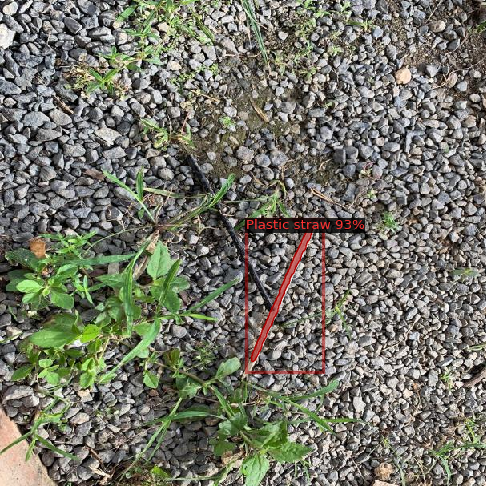

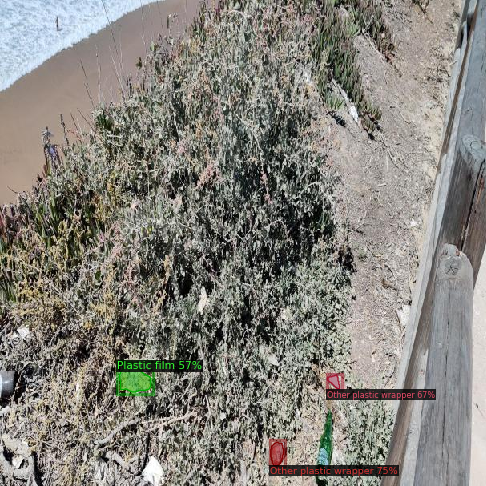

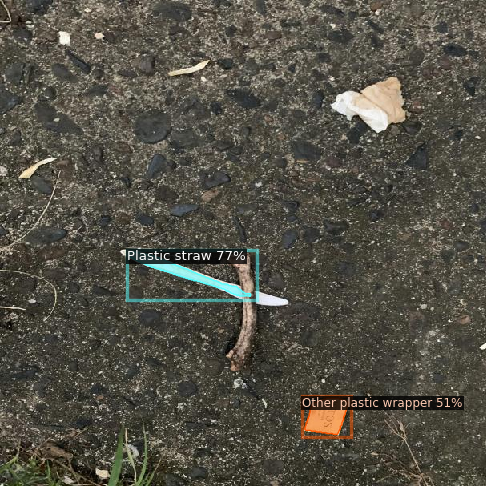

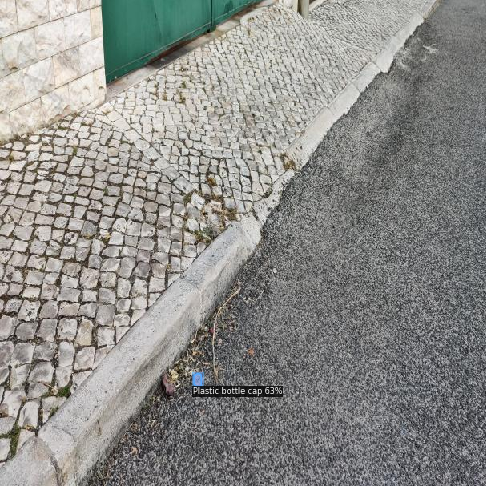

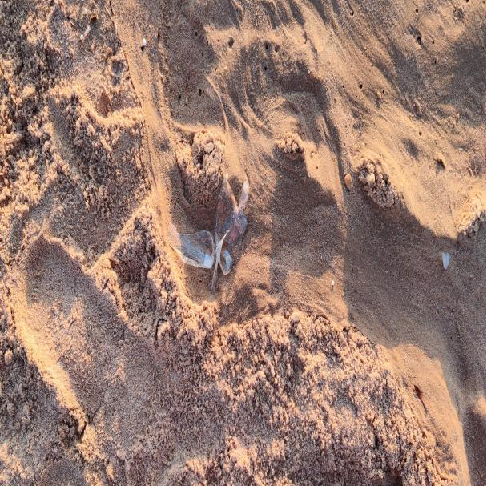

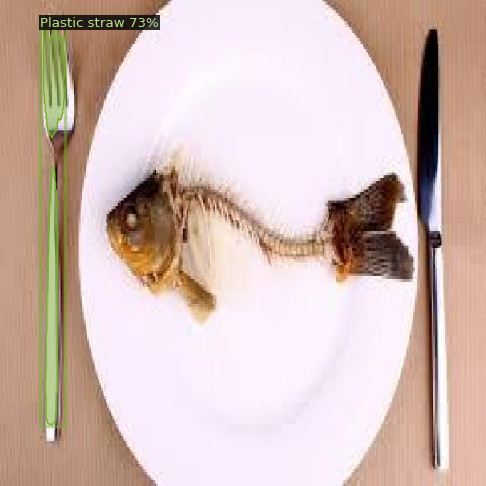

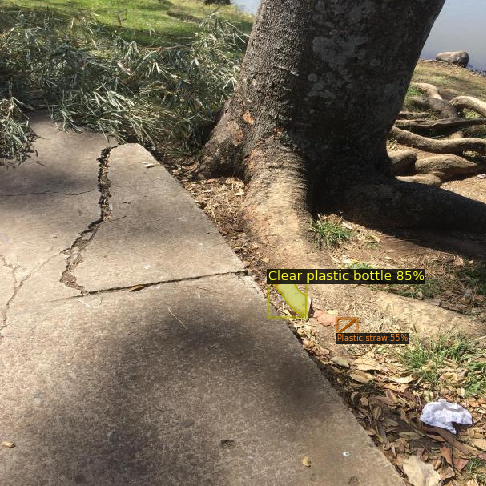

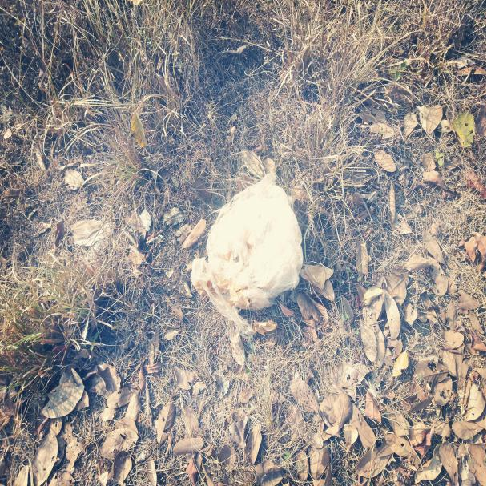

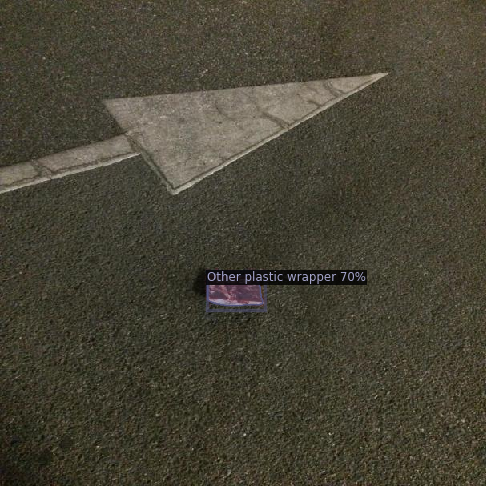

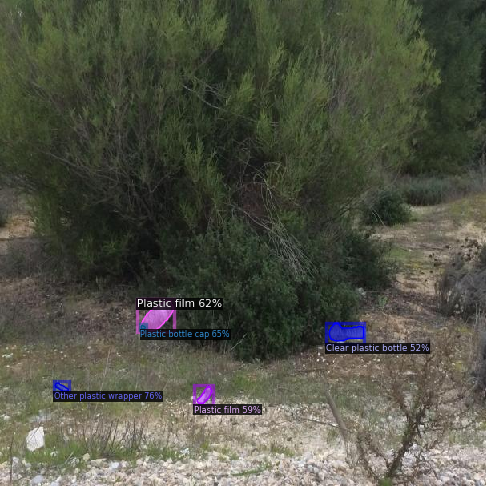

In [23]:
test_metadata = MetadataCatalog.get("my_dataset_test")
from detectron2.utils.visualizer import ColorMode
import glob
import cv2
from google.colab.patches import cv2_imshow  # Use this if working in Google Colab

# Counter to track the number of images displayed
count = 0

# Loop through images in the specified directory
for imageName in glob.glob('/content/valid/*jpg'):
    if count >= 10:  # Stop after displaying 5 images
        break

    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=test_metadata,
        scale=0.8,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display the image
    cv2_imshow(out.get_image()[:, :, ::-1])

    count += 1  # Increment the counter


In [24]:
# evaluation
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


WARNING [01/14 16:46:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/14 16:46:56 d2.data.datasets.coco]: Loaded 110 images in COCO format from /content/valid/_annotations.coco.json
[01/14 16:46:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/14 16:46:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/14 16:46:56 d2.data.common]: Serializing 110 elements to byte tensors and concatenating them all ...
[01/14 16:46:56 d2.data.common]: Serialized dataset takes 0.13 MiB
[01/14 16:46:56 d2.evaluation.evaluator]: Start inference on 110 batches
[01/14 16:46:57 d2.evaluation.evaluator]: Inference done 11/110. Dataloading: 0.0013 s/iter. Inference: 0.0749 s/iter. Eval: 0.0018 s/iter. Total: 0.0781 s/iter. ETA=0:00:07
[01/14 16:47:02 d2.evaluation.